In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [5]:
np.random.seed(1337)

In [6]:
(X_train, _), (X_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
image_size = X_train.shape[1]
print(image_size)

28


In [8]:
X_train = np.reshape(X_train, (-1, image_size, image_size, 1))
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, (-1, image_size, image_size, 1))
X_test = X_test.astype('float32') / 255

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
X_test.shape

(10000, 28, 28, 1)

In [12]:
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

# We will cut off the values that fell out of the range [0,1] after adding the noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

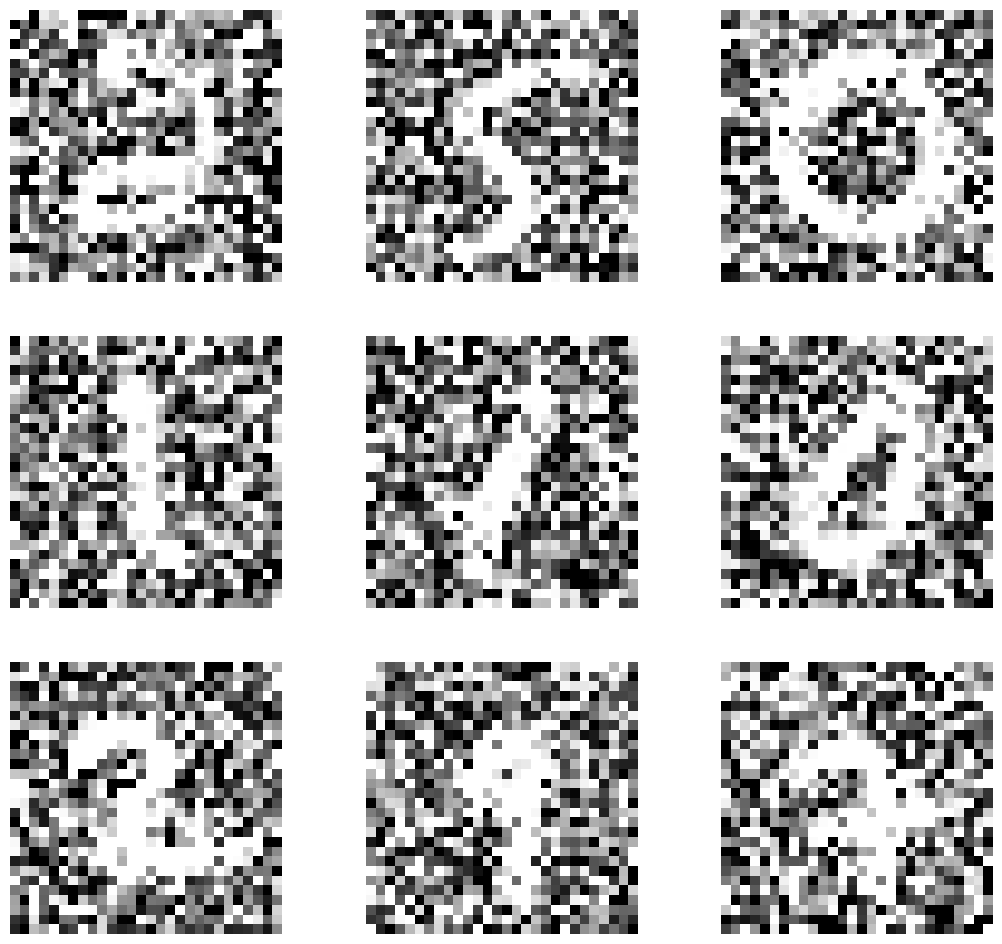

In [13]:
nrows = 3
ncols = 3

# We prepare a panel for drawing each of the images
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(13, 12)

# We extract nrows*ncols images at random
ix = np.random.randint(low=0, high=X_train_noisy.shape[0], size=nrows*ncols)
chosen_imgs = X_train_noisy[ix]

# We plot each image separately
i = 0
for row in ax:
    for col in row:
        # Before displaying them we change the dimension of each image from (image_size,image_size,1)
        # to (image_size, image_size) as this is required by matplotlib
        img = chosen_imgs[i].reshape(image_size, image_size)
        col.imshow(img, cmap='gray')
        col.axis('off')
        i += 1
        
plt.show()       

In [14]:
input_shape = (image_size, image_size, 1)
latent_dim = 16

In [15]:
# Kernel size
kernel_size = 3

# Number of filters in convolutional layers
layer_filters = [32, 64]

In [16]:
# We have the input layer
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Afterwards we have two convolutional layers
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# We will read and preserve the dimensions of the tensor to obtain
# (None, 7, 7, 64) 
shape = K.int_shape(x)

# Then we have a flattening layer
x = Flatten()(x)

# and then the dense layer that generates the latent representation
latent_outputs = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs=inputs, outputs=latent_outputs, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 16)             │        50,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Kernel size
kernel_size = 3

# Number of filters in convolutional layers
layer_filters = [32, 64]

In [18]:
# First we have the input layer
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# afterwards we have one dense layer that allows us to 
# transform the input into (None, 7, 7, 64)
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# then we add transposed convolutional layers but in a reversed order compared to the encoder
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                    kernel_size=kernel_size,
                    strides=2,
                    activation='relu',
                    padding='same')(x)

# then we add one more convolutional layer to control the channel dimension   
x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

# and one activation later with the sigmoid activation function
outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')
decoder.summary(line_length=110)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)                     │ (None, 16)                          │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense (Dense)                                  │ (None, 3136)                        │              53,312 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, 7, 7, 64)                    │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_transpose (Conv2DTranspose)             │ (None, 14, 14, 64)                  │              36,928 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose)           │ (None, 28, 28, 32)                  │              18,464 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose)           │ (None, 28, 28, 1)                   │                 289 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ decoder_output (Activation)                    │ (None, 28, 28, 1)                   │                   0 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │        69,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       108,993 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,001 (695.32 KB)

 Trainable params: 178,001 (695.32 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
autoencoder.compile(loss='mse', optimizer='adam')

In [23]:
batch_size = 128
epochs = 10

In [24]:
autoencoder.fit(X_train_noisy,
                X_train,
                validation_data=(X_test_noisy, X_test),
                epochs=epochs,
                batch_size=batch_size)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0832 - val_loss: 0.0324
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0286 - val_loss: 0.0219
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0216 - val_loss: 0.0197
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0196 - val_loss: 0.0186
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0184 - val_loss: 0.0178
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0176 - val_loss: 0.0174
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0167 - val_loss: 0.0167
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0164 - val_loss: 0.0170
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0161 - val_loss: 0.0165


In [25]:
autoencoder.save('autoencoder.keras')

In [26]:
autoencoder = keras.models.load_model("autoencoder.keras")

In [27]:
X_decoded = autoencoder.predict(X_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


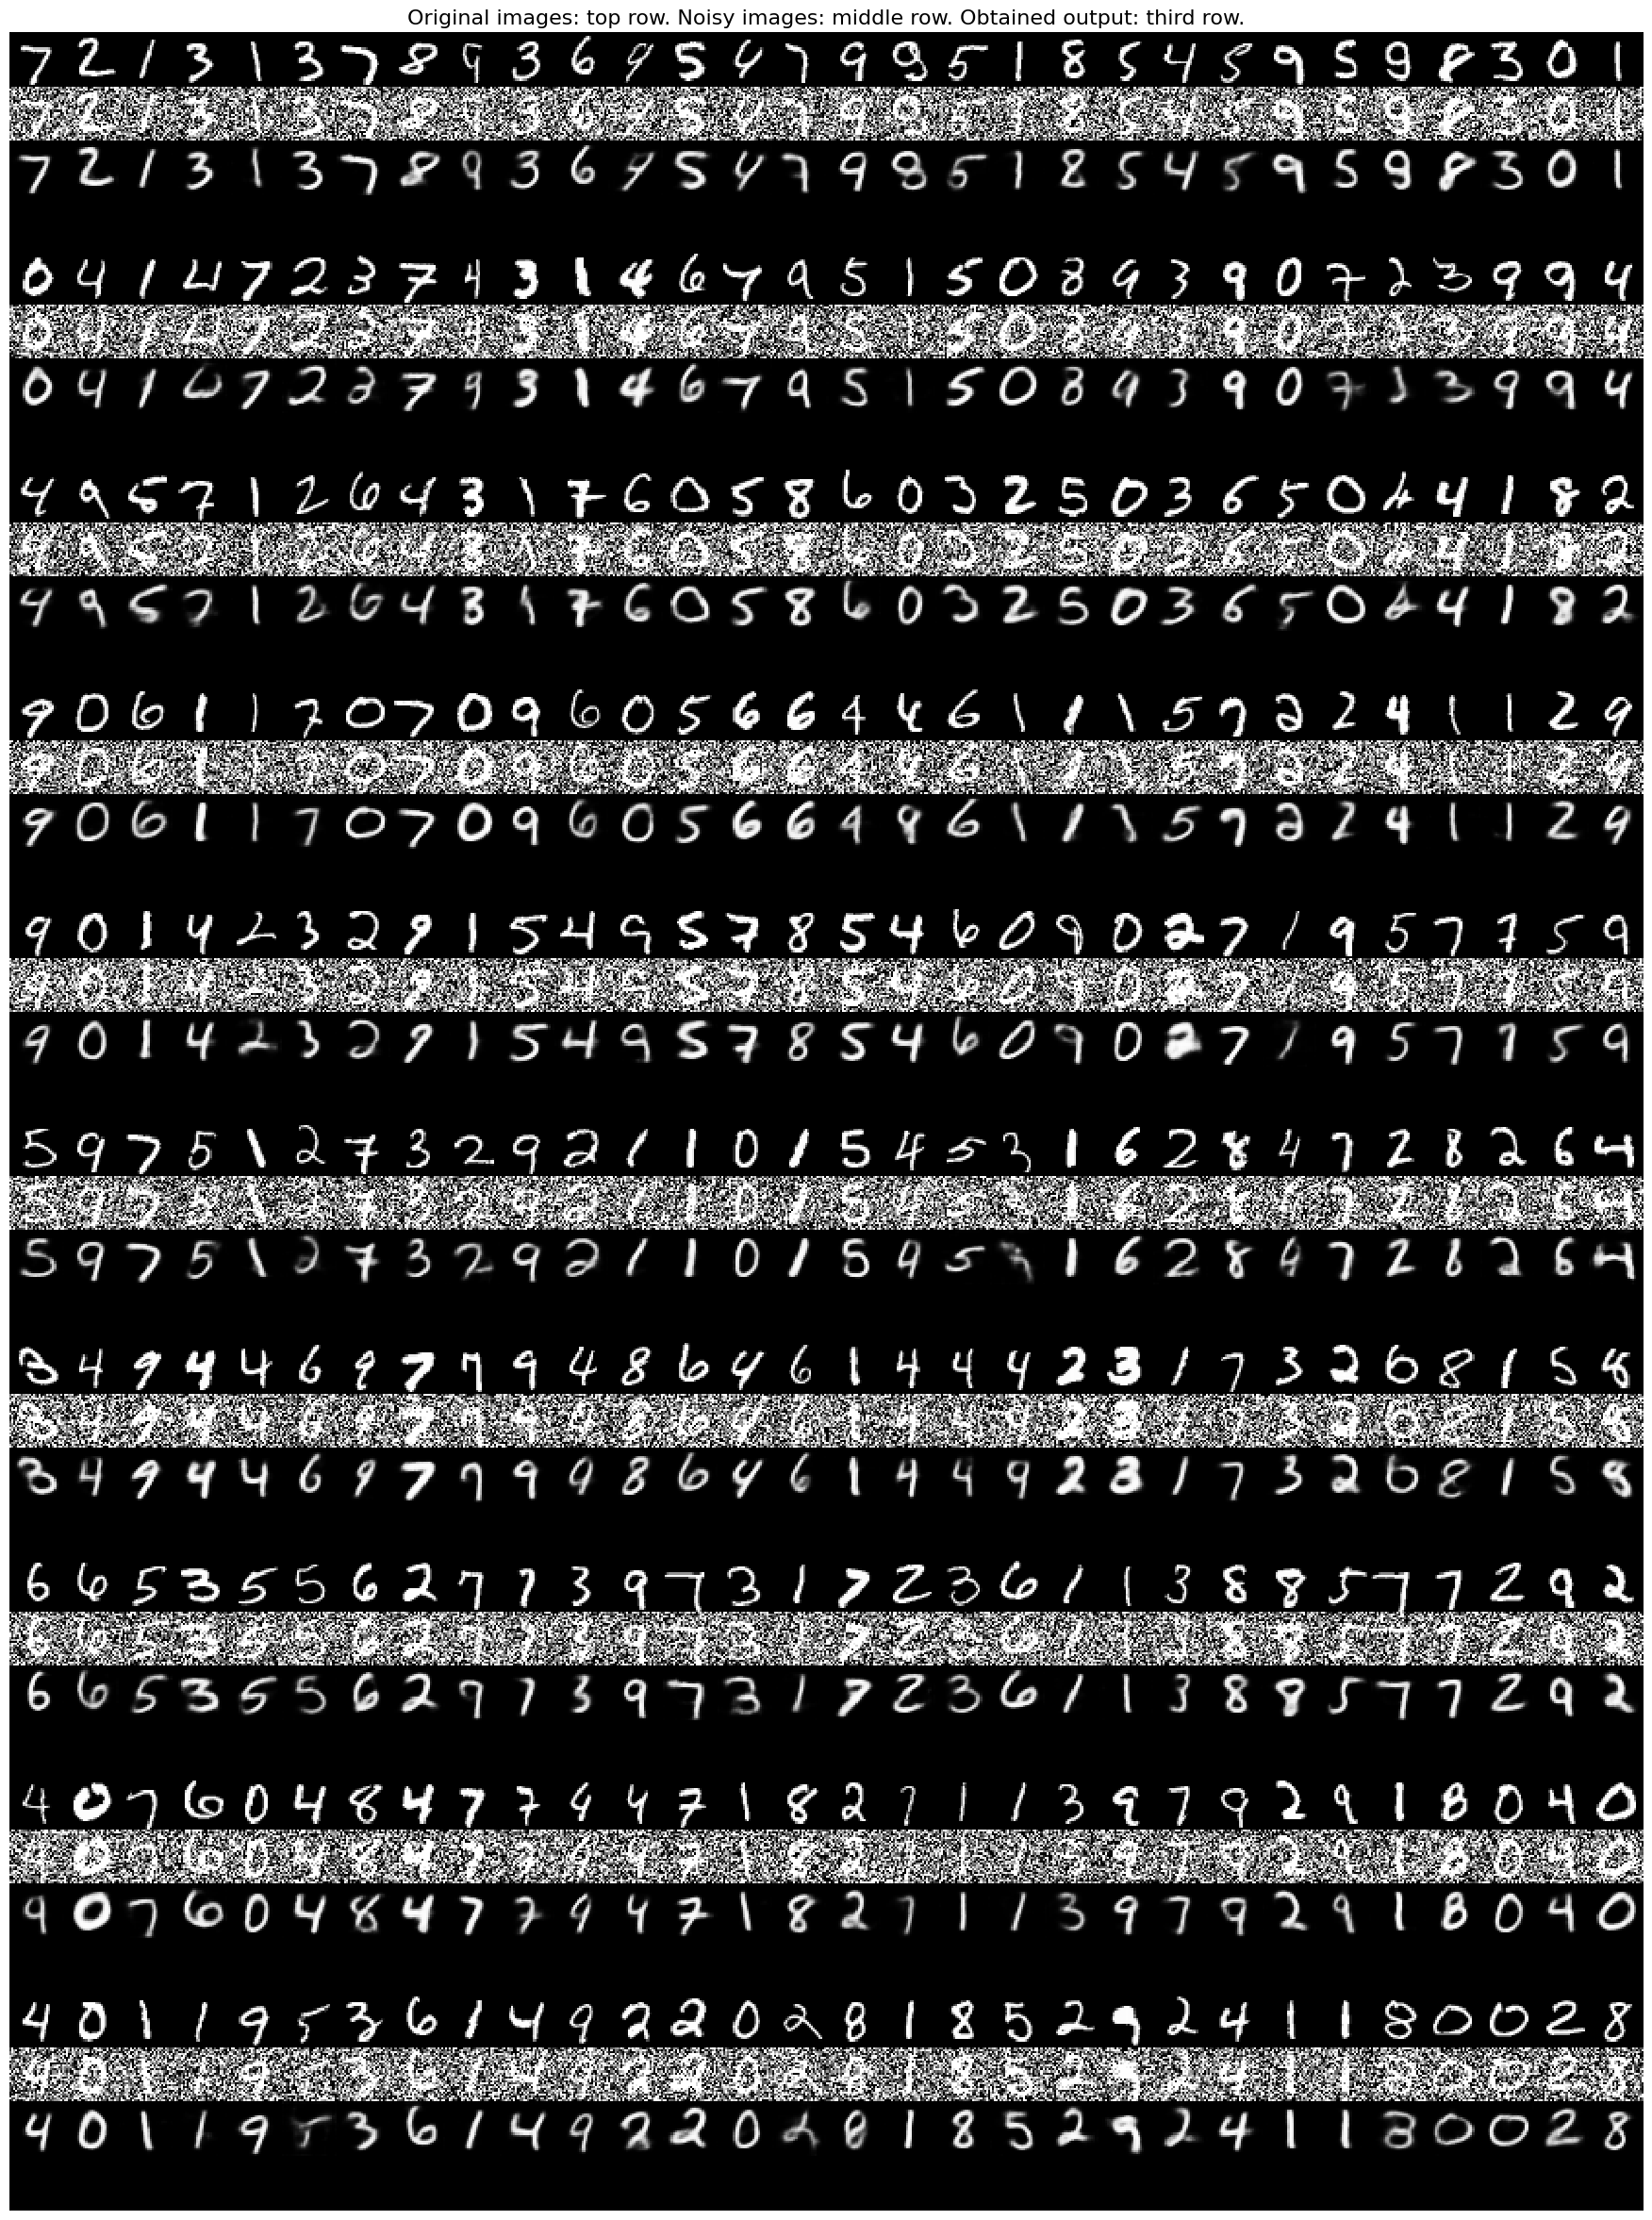

In [28]:
# We are preparing the panel for plotting the images
plt.figure(figsize=(30, 30))

# We extract 10x30 images
rows, cols = 10, 30
num = rows * cols

# We select the images: first the original ones, then the noisy ones, and then those generated by the autoencoder
imgs = np.concatenate([X_test[:num], X_test_noisy[:num], X_decoded[:num], np.zeros_like(X_test[:num])])
imgs = imgs.reshape((rows * 4, cols, image_size, image_size))

# We organize the images such that they have the described shape
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 4, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.axis('off')
plt.title('Original images: top row. '
          'Noisy images: middle row. '
          'Obtained output: third row.', fontsize = 16)

# We are plotting the images
plt.imshow(imgs, interpolation='none', cmap='gray')

# We store the image generated in this way
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()